In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import h5py 
import datetime
import glob
import copy
from calendar import monthrange
from cartopy.io.shapereader import Reader
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

In [2]:
def compilealldatatarget(lats,lons,filelist,footprintradio,targetname1,targetname2):
    
    minlat = (min(lats)-footprintradio/110.0)
    maxlat = (max(lats)+footprintradio/110.0)
    minlon = (min(lons)-footprintradio/110.0)
    maxlon = (max(lons)+footprintradio/110.0)
    
    ilats = np.arange(int(maxlat)-int(minlat)+1,dtype=int)+int(minlat)
    ilons = np.arange(int(maxlon)-int(minlon)+1,dtype=int)+int(minlon)


    for ifile,filename in enumerate(filelist):
        datos = h5py.File(filename,'r')
        #print(ifile)
        for lat in ilats:
            for lon in ilons:
                #print(lat,lon)
                try:
                    gridname = '%iN%iW' % (lat,lon)
                    #print(gridname)
                    lt = datos[gridname]['lat'][()]
                    ln = datos[gridname]['lon'][()]
                    #print(ln)
                    tid = datos[gridname]['/Sounding/target_id'][()] 
                    tname = datos[gridname]['/Sounding/target_name'][()]
                    tidstr = tid.astype('U')
                    tnamestr = tname.astype('U')
                    mask = ((lt <= maxlat) & (lt >= minlat) & \
                           (ln <= maxlon) & (ln >= minlon) & \
                           ((tidstr == targetname1) | (tidstr == targetname2)))
                    #print(mask)
                    data_inter = datos[gridname][mask]
                    #print(data_inter)
                    
                    try:
                        data = np.append(data,data_inter)
                        #print('matrix exists')
                    except:
                        data = copy.copy(data_inter)
                        #print(data)
                        #print('new matrix')
                    print(data.shape)
                except:
                    print('exception: no dataset')
                #print 'data:',len(data)
                #print max(data['lat']), min(data['lat']), max(data['lon']), min(data['lon'])

        datos.close()
    #plt.plot(data['lon'],data['lat'],'.')
    #plt.show()
    return data


In [3]:
def datacorrection_ml(dset,data,corrtype):
    
    cont = 0
    t0 = datetime.datetime.utcfromtimestamp(0.0)
    datacorr = copy.copy(data)
    print(data[name])
    for ii,ele in enumerate(dset['year']):
        
        try:
            tmin = (datetime.datetime(year=dset['year'][ii],month=dset['month'][ii],day=dset['day'][ii]-1,hour=0,minute=0,second=0)-t0).total_seconds()
        except:
            maxdays = monthrange(dset['year'][ii],dset['month'][ii]-1)
            tmin = (datetime.datetime(year=dset['year'][ii],month=dset['month'][ii]-1,day=monthrange,hour=0,minute=0,second=0)-t0).total_seconds()
        try:
            tmax = (datetime.datetime(year=dset['year'][ii],month=dset['month'][ii],day=dset['day'][ii]+1,hour=23,minute=59,second=59)-t0).total_seconds() 
        except:
            tmax = (datetime.datetime(year=dset['year'][ii],month=dset['month'][ii]+1,day=1,hour=23,minute=59,second=59)-t0).total_seconds()
        
        mask = (tmin <= data['tepoch']) & (tmax >= data['tepoch'])
        
        if corrtype == 0:
            datacorr[name][mask] = (data[name][mask]*data[psurf][mask] - dset['xCO2altz'][ii]*dset['psurfaltz'][ii])/(data[psurf][mask]-dset['psurfaltz'][ii])
        if corrtype == 1:
            datacorr[name][mask] = (data[name][mask]*data[psurf][mask] - dset['xCO2altz'][ii]*dset['psurfaltz'][ii])
        if corrtype == 2:
            pass
        
        cont = cont + len(data[name][mask])
        #print(len(data[name][mask]))
    print(cont)
    print(data[name].shape)
    print(data[name])
    print(datacorr[name].shape)
    print(datacorr[name])
    return datacorr

In [4]:
def makematrixfromcompileddata(lats,lons,data,name,footprintradio,flag):
    
    #print 'data:'
    #print max(data['lat']), min(data['lat']), max(data['lon']), min(data['lon'])
    matrix=np.zeros((len(lons),len(lats)),dtype=np.float64)
    countermatrix=np.zeros((len(lons),len(lats)),dtype=int)
    stdmatrix=np.zeros((len(lons),len(lats)),dtype=np.float64)
    for ilat,lat in enumerate(lats):
        for ilon,lon in enumerate(lons):
            distances2=np.array((data['lat']-lat)**2+(data['lon']-lon)**2)
            conditions=(footprintradio**2 > distances2)
            #print(conditions)
            index=np.where(conditions)[0]
            if len(index) > 0:
                vec=data[name][index]
                #print(vec)
                matrix[ilon,ilat]=np.average(vec)
                #print(matrix[ilon,ilat],ilon,ilat)
                stdmatrix[ilon,ilat]=np.std(vec)
                countermatrix[ilon,ilat]=len(vec)
            else:
                #print(matrix[ilon,ilat],ilon,ilat)
                pass
                #plt.plot(data['lon'],data['lat'],'b.')
                #plt.plot([lon],[lat],'ro')
                #plt.show()
    errmatrix=stdmatrix/np.sqrt(countermatrix)
    #print(matrix)
    if flag=='full':
        return matrix.T,stdmatrix.T, errmatrix.T
    else:
        return matrix.T


In [5]:
def matrixforinterval(tmin,tmax,dataorg,flag):
    index=np.where(np.logical_and(tmin <= dataorg['tepoch'],tmax >= dataorg['tepoch']))[0]
    data=dataorg[index]
    matrix,stdmat,errmat=makematrixfromcompileddata(lats,lons,data,name,footprintradio,flag)
    if flag=='full':
        return matrix,stdmat, errmat
    else:
        return matrix


In [6]:
def mapper1x2(title1,title2,fontsize,ticksize,lvls1,lvls2,matrix1,matrix2,figname,savefig):
    plt.figure(figsize=(14,14))
    mxmap1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree()) 
    mxmap1.add_feature(cfeature.LAND)
    mxmap1.add_feature(cfeature.OCEAN)
    mxmap1.add_feature(cfeature.COASTLINE)
    mxmap1.add_feature(cfeature.BORDERS, linestyle=':')
    mxmap1.add_feature(cfeature.LAKES, alpha=0.5)
    mxmap1.add_feature(cfeature.RIVERS)
    mxmap1.add_feature(cfeature.STATES.with_scale('10m'))
    mxmap1.set_extent((lonmin,lonmax,latmin,latmax))
    #mxmap.xaxis.set_visible(True)
    #mxmap.yaxis.set_visible(True)
    
    glines1 = mxmap1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    glines1.xformatter = LongitudeFormatter()
    glines1.yformatter = LatitudeFormatter()
    glines1.top_labels = None
    glines1.right_labels = None
    glines1.xlabel_style = {'size': 16}
    glines1.ylabel_style = {'size': 16}
    
    
    plt.contourf(lons, lats, matrix1, levels = lvls1,cmap=plt.get_cmap("jet"),transform=ccrs.PlateCarree())
    plt.title(title1,size=fontsize)
    plt.xlabel("Longitude",size=fontsize)
    plt.ylabel("Latitude",size=fontsize)
    cbar= plt.colorbar(fraction=0.041, pad=.02)
    cbar.set_label("ppm", size=fontsize, labelpad=0.8)
    cbar.ax.tick_params(labelsize=ticksize)
    
    
    mxmap2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree()) 
    mxmap2.add_feature(cfeature.LAND)
    mxmap2.add_feature(cfeature.OCEAN)
    mxmap2.add_feature(cfeature.COASTLINE)
    mxmap2.add_feature(cfeature.BORDERS, linestyle=':')
    mxmap2.add_feature(cfeature.LAKES, alpha=0.5)
    mxmap2.add_feature(cfeature.RIVERS)
    mxmap2.add_feature(cfeature.STATES.with_scale('10m'))
    mxmap2.set_extent((lonmin,lonmax,latmin,latmax))
    #mxmap.xaxis.set_visible(True)
    #mxmap.yaxis.set_visible(True)

    glines2 = mxmap2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    glines2.xformatter = LongitudeFormatter()
    glines2.yformatter = LatitudeFormatter()
    glines2.top_labels = None
    glines2.right_labels = None
    glines2.left_labels = None
    glines2.xlabel_style = {'size': 16}
    glines2.ylabel_style = {'size': 16}
    
    plt.contourf(lons, lats, matrix2, levels = lvls2,cmap=plt.get_cmap("jet"),transform=ccrs.PlateCarree())
    plt.title(title2,size=fontsize)
    plt.xlabel("Longitude",size=fontsize)
    plt.ylabel("Latitude",size=fontsize)
    cbar= plt.colorbar(fraction=0.041, pad=.02)
    cbar.set_label("ppm", size=fontsize, labelpad=0.8)
    cbar.ax.tick_params(labelsize=ticksize)
    
    if savefig==1:
        plt.savefig(figname)
    plt.show()

In [7]:
def mapper3x2(title1,title2,fontsize,ticksize,lvls,matrices,figname,savefig):
    
    plt.figure(figsize=(20,30))
    for ii,matrix in enumerate(matrices):
        mxmap = plt.subplot(3, 2, ii+1, projection=ccrs.PlateCarree()) 
        mxmap.add_feature(cfeature.LAND)
        mxmap.add_feature(cfeature.OCEAN)
        mxmap.add_feature(cfeature.COASTLINE)
        mxmap.add_feature(cfeature.BORDERS, linestyle=':')
        mxmap.add_feature(cfeature.LAKES, alpha=0.5)
        mxmap.add_feature(cfeature.RIVERS)
        mxmap.add_feature(cfeature.STATES.with_scale('10m'))
        mxmap.set_extent((lonmin,lonmax,latmin,latmax))
        #mxmap.xaxis.set_visible(True)
        #mxmap.yaxis.set_visible(True)
    
        glines = mxmap.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        glines.xformatter = LongitudeFormatter()
        glines.yformatter = LatitudeFormatter()
        glines.top_labels = None
        glines.right_labels = None
        if (ii+1)%2==0:
            glines.left_labels = None
        glines.xlabel_style = {'size': 16}
        glines.ylabel_style = {'size': 16}
    
        plt.contourf(lons, lats, matrices[ii], levels = lvls[ii],cmap=plt.get_cmap("jet"),transform=ccrs.PlateCarree())
        if ii==0:
            plt.title(title1,size=fontsize)
        if ii==1:
            plt.title(title2,size=fontsize)
        if (ii==2) | (ii==3):
            plt.title('StDev Matrix',size=fontsize)
        if (ii==4) | (ii==5):
            plt.title('Error Matrix',size=fontsize)
        plt.xlabel("Longitude",size=fontsize)
        plt.ylabel("Latitude",size=fontsize)
        cbar= plt.colorbar(fraction=0.041, pad=.02)
        if (ii+1)%2 == 0:
            cbar.set_label("ppm", size=fontsize, labelpad=0.8)
        cbar.ax.tick_params(labelsize=ticksize)

    #plt.tight_layout()
    if savefig==1:
        plt.savefig(figname)
    plt.show()

In [8]:
nx=50
ny=50

latmin = 18.1
latmax = 20.8
lonmin = -100.5
lonmax = -97.7
footprintradio = 5.0/110.0
pathname = 'f:\\CCA\\NASAGESDISC\\OCO3L2Lite\\mexico\\mexico_oco3_lite_2020*.h5'
targetname1 = 'fossil0036'
targetname2 = 'volcano0002'
name = '/xco2'
psurf = '/Retrieval/psurf'
dsetpath = 'F:\\gitCCA\\cca-jupyter\\data\\sam_zmvm_altzbgrd.npz'
#xco2altz = 412.4
#psurfaltz = 633.72

corrtype = 0        # 0 para xCO2 ML, 1 para deltaxCO2, 2 para no correcion

In [9]:
to=datetime.datetime.utcfromtimestamp(0.0)

lats=latmin+(latmax-latmin)*np.arange(ny)/(ny-1)
lons=lonmin+(lonmax-lonmin)*np.arange(nx)/(nx-1)


lista=glob.glob(pathname)
#print(lista)

data = compilealldatatarget(lats,lons,lista,footprintradio,targetname1,targetname2)
print(data.shape)


(0,)
exception: no dataset
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
exception: no dataset
(0,)
(190,)
(195,)
exception: no dataset
(195,)
(309,)
(607,)
(607,)
exception: no dataset
(607,)
exception: no dataset
(607,)
(614,)
(823,)
(832,)
exception: no dataset
exception: no dataset
(1471,)
(1799,)
exception: no dataset
exception: no dataset
(1802,)
(1802,)
(1802,)
(1803,)
(1915,)
exception: no dataset
(1915,)
(1928,)
(2848,)
(3231,)
(3231,)
(3231,)
(3486,)
(3536,)
exception: no dataset
(3551,)
(3638,)
(3651,)
exception: no dataset
(3653,)
(4295,)
(4733,)
exception: no dataset
(4734,)
(4890,)
(4976,)
exception: no dataset
exception: no dataset
(5034,)
(5262,)
exception: no dataset
(5262,)
(5270,)
(5526,)
(5526,)
(5549,)
(5624,)
exception: no dataset
(5624,)
exception: no dataset
exception: no dataset
exception: no dataset
exception: no dataset
(5630,)
(5795,)
(5854,)
exception: no dataset
(5877,)
(6036,)
exception: no dataset
exception: no dataset
exception: no dataset
(6049,)
(6253,

In [10]:
dset = np.load(dsetpath)
datos = datacorrection_ml(dset,data,corrtype)

[414.75750732 413.32675171 415.31057739 ... 409.51849365 409.42758179
 409.16815186]
6699
(6699,)
[414.75750732 413.32675171 415.31057739 ... 409.51849365 409.42758179
 409.16815186]
(6699,)
[427.60591449 422.9887659  432.28474059 ... 407.34644084 406.83687834
 405.31050107]


In [11]:
tmintest=(datetime.datetime(2020,4,10,0,0,0)-to).total_seconds()
tmaxtest=(datetime.datetime(2020,4,12,0,0,0)-to).total_seconds()
masktest = (tmintest <= data['tepoch']) & (tmaxtest >= data['tepoch'])
datarowminus1 = 14
print(dset['xCO2altz'][datarowminus1],dset['psurfaltz'][datarowminus1])
datatest = copy.copy(data[masktest])
datatest[name] = (datatest[name]*datatest[psurf] - dset['xCO2altz'][datarowminus1]*dset['psurfaltz'][datarowminus1])/(datatest[psurf]-dset['psurfaltz'][datarowminus1])
print(datatest[name].shape)
print(datos[name][masktest].shape)
np.array_equal(datatest[name],datos[name][masktest])

410.6806284 639.4017546
(961,)
(961,)


True

In [26]:
datemin = datetime.datetime(2020,5,1,0,0,0)
datemax = datetime.datetime(2020,7,31,23,59,59)
tmin=(datemin-to).total_seconds()
tmax=(datemax-to).total_seconds()
flag='full'
matrix1,stdmat1,errmat1=matrixforinterval(tmin,tmax,data,flag)
matrix2,stdmat2,errmat2=matrixforinterval(tmin,tmax,datos,flag)
#np.save('matrixDelta0605',matrix)

<ipython-input-4-eadd81ce8b84>:27: RuntimeWarning: invalid value encountered in true_divide
  errmatrix=stdmatrix/np.sqrt(countermatrix)


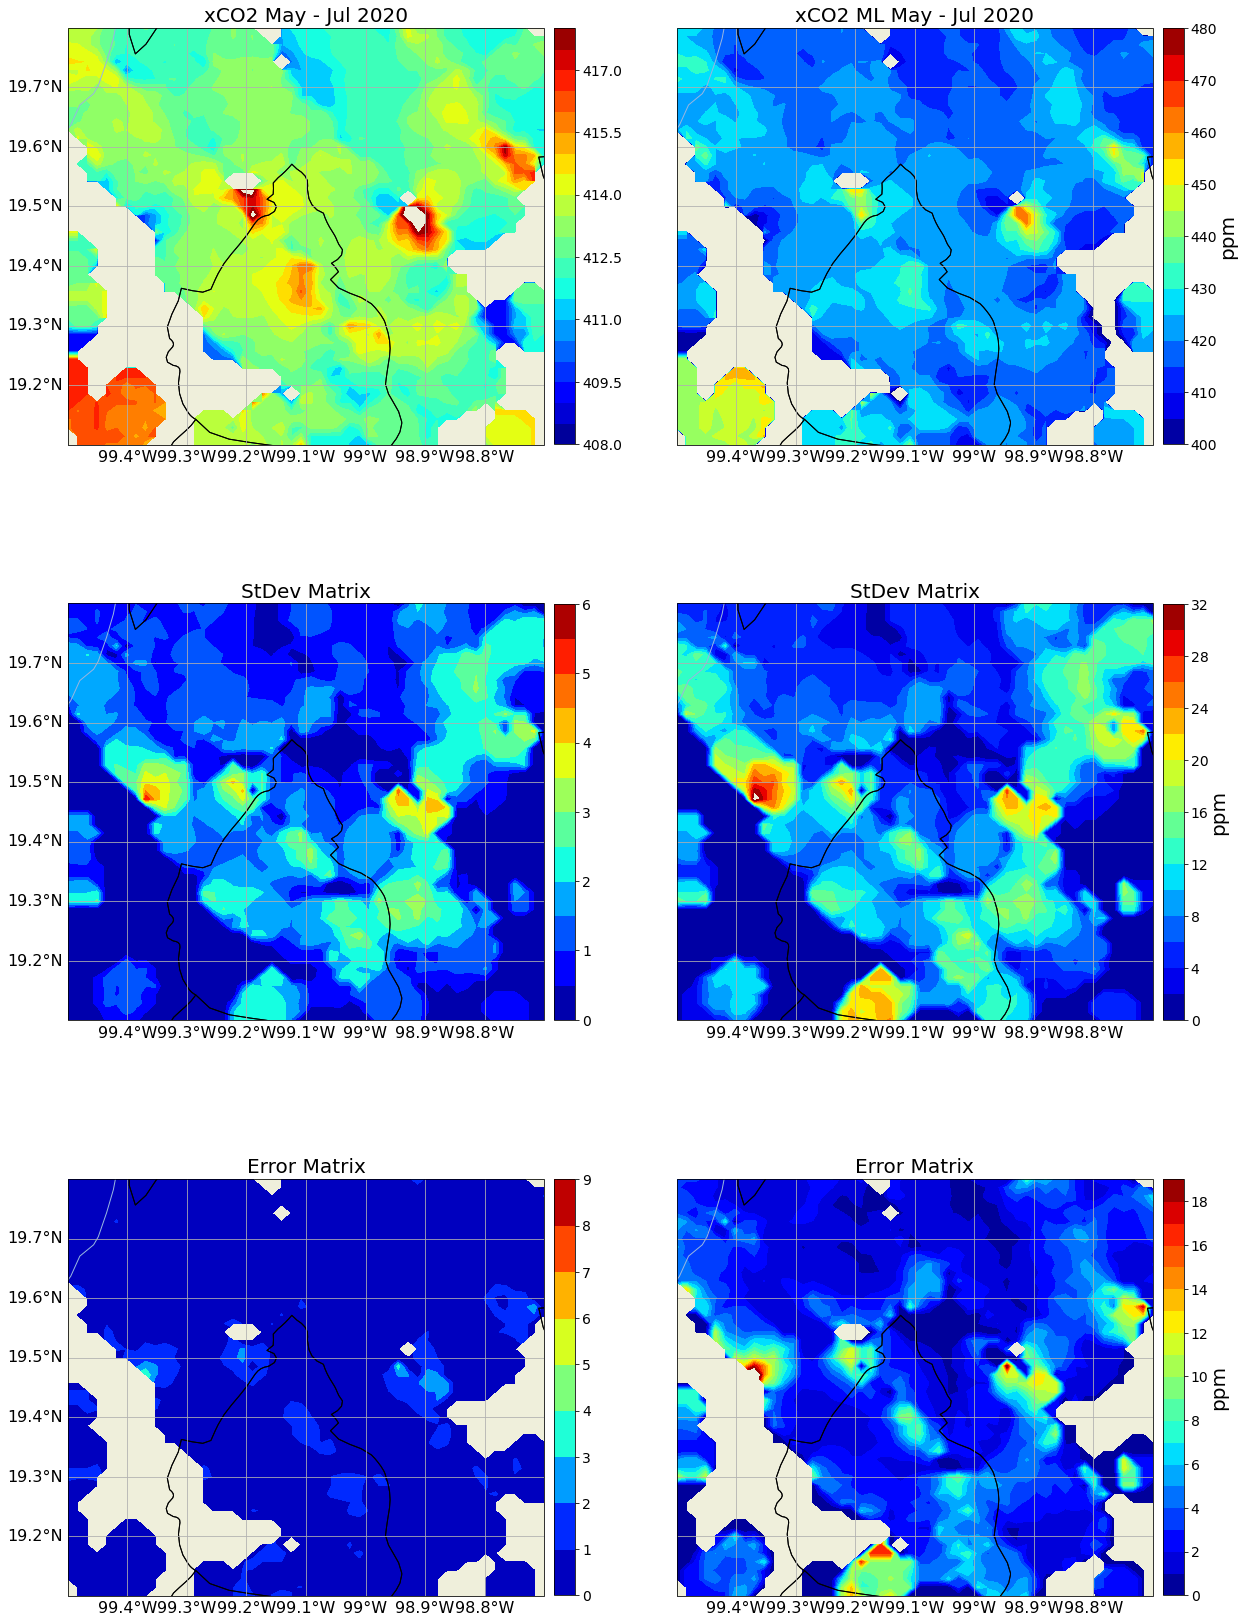

In [29]:
tyr= datemin.strftime("%Y")
if datemin.strftime("%b") == datemax.strftime("%b"):
    tmt= datemin.strftime("%b") + " "
else:
    tmt = datemin.strftime("%b") + ' - ' + datemax.strftime("%b") + " "
tdy=''
mldxco2 = 'ML '
title1 = 'xCO2 ' + tmt + tdy + tyr
title2 = 'xCO2 ' + mldxco2 + tmt + tdy + tyr

fontsize = 20
ticksize = 14

lvls1 = np.arange(408,418.5,0.5)
lvls2 = np.arange(400,485,5)
lvls3 = np.arange(0,6.5,0.5)
lvls4 = np.arange(0,34,2)
lvls5 = np.arange(0,10,1)
lvls6 = np.arange(0,20,1)

matrices = [matrix1,matrix2,stdmat1,stdmat2,errmat1,errmat2]
lvls = [lvls1,lvls2,lvls3,lvls4,lvls5,lvls6]

figname = 'f:\\gitCCA\\cca-jupyter\\figures\\comp\\xco2_t2_allmat.png'
savefig = 0 # 0 for no 1 for yes
# Creates the map

mapper3x2(title1,title2,fontsize,ticksize,lvls,matrices,figname,savefig)

In [22]:
datemin = datetime.datetime(2020,5,1,0,0,0)
datemax = datetime.datetime(2020,7,31,23,59,59)
tmin=(datemin-to).total_seconds()
tmax=(datemax-to).total_seconds()
flag='full'
matrix1,stdmat1,errmat1=matrixforinterval(tmin,tmax,data,flag)
matrix2,stdmat2,errmat2=matrixforinterval(tmin,tmax,datos,flag)
#np.save('matrixDelta0605',matrix)

<ipython-input-4-eadd81ce8b84>:27: RuntimeWarning: invalid value encountered in true_divide
  errmatrix=stdmatrix/np.sqrt(countermatrix)


<ipython-input-23-c1eb78886773>:21: RuntimeWarning: invalid value encountered in less
  mat1=np.where(errmat1<8,matrix1,np.nan)
<ipython-input-23-c1eb78886773>:22: RuntimeWarning: invalid value encountered in less
  err1=np.where(errmat1<8,errmat1,np.nan)
<ipython-input-23-c1eb78886773>:23: RuntimeWarning: invalid value encountered in less
  std1=np.where(errmat1<8,stdmat1,np.nan)
<ipython-input-23-c1eb78886773>:24: RuntimeWarning: invalid value encountered in less
  mat2=np.where(errmat2<8,matrix2,np.nan)
<ipython-input-23-c1eb78886773>:25: RuntimeWarning: invalid value encountered in less
  err2=np.where(errmat2<8,errmat2,np.nan)
<ipython-input-23-c1eb78886773>:26: RuntimeWarning: invalid value encountered in less
  std2=np.where(errmat2<8,stdmat2,np.nan)


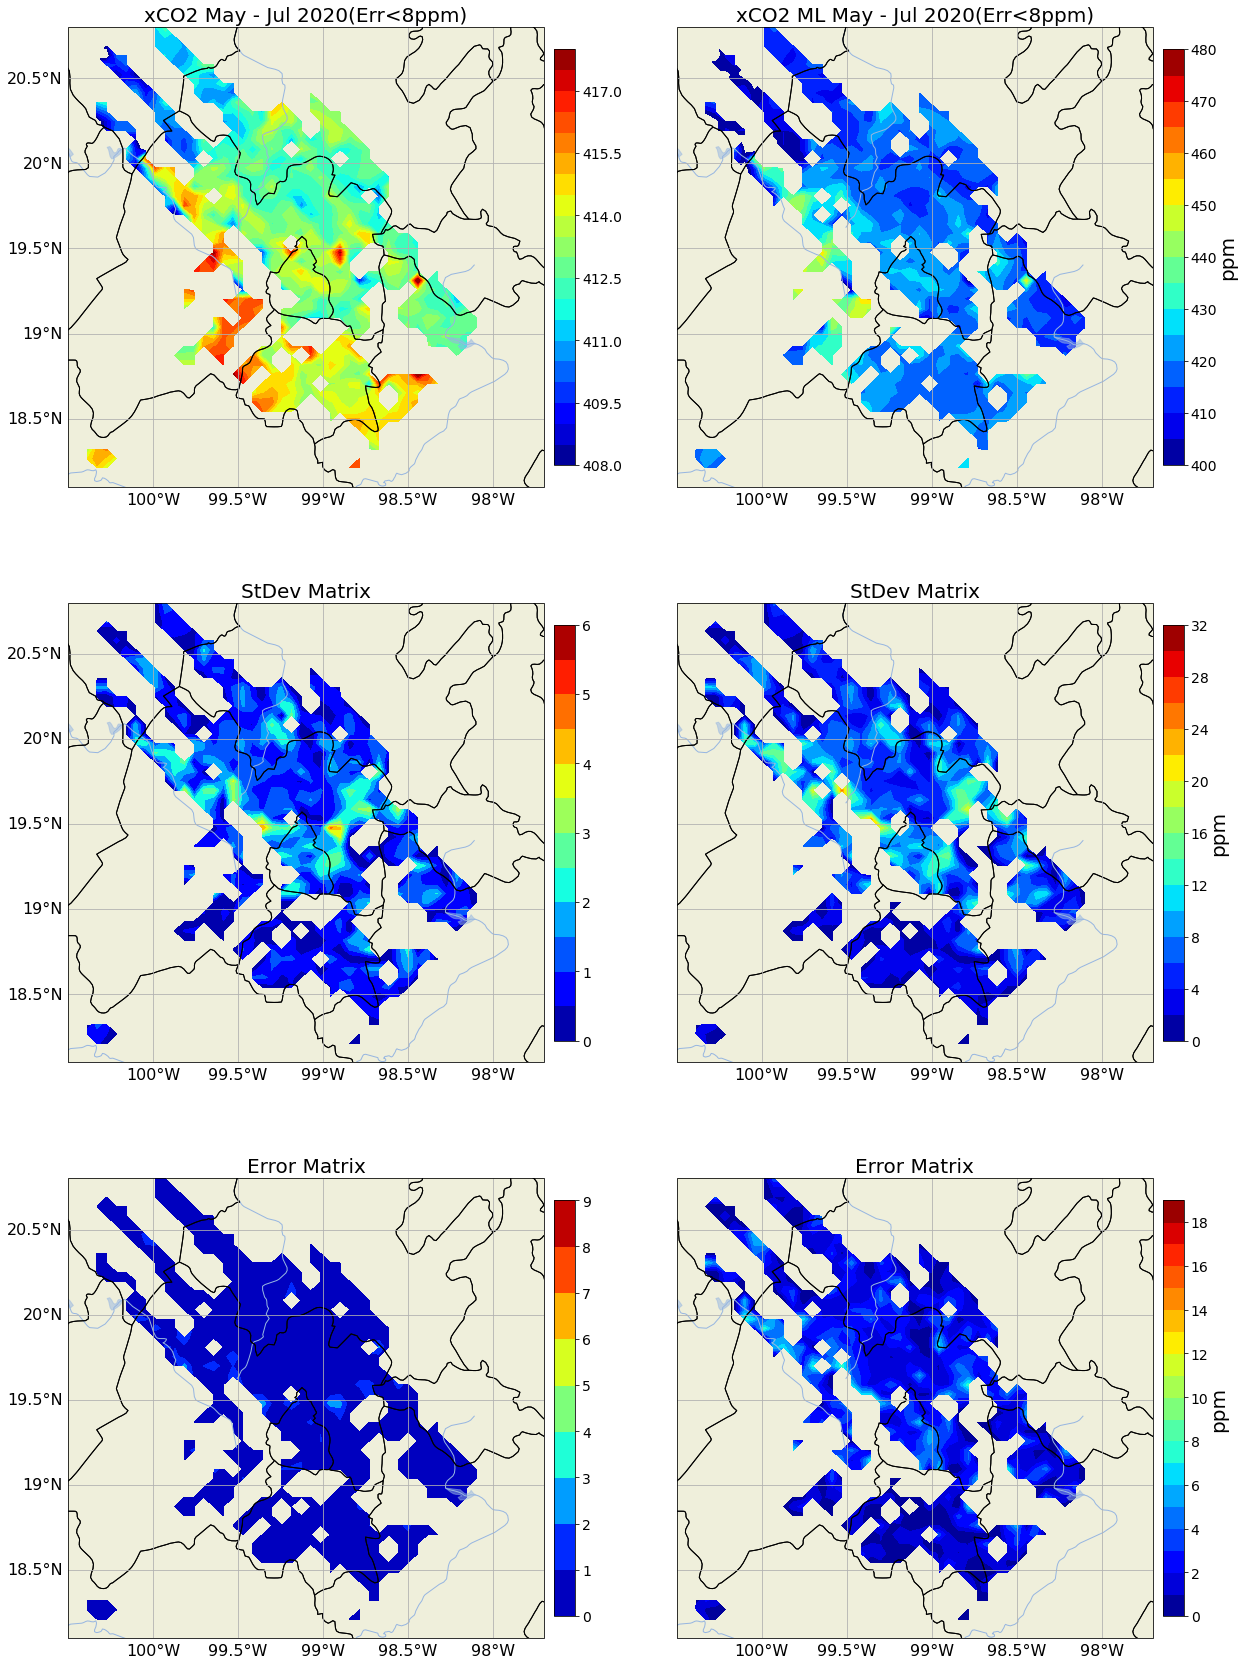

In [23]:
tyr= datemin.strftime("%Y")
if datemin.strftime("%b") == datemax.strftime("%b"):
    tmt= datemin.strftime("%b") + " "
else:
    tmt = datemin.strftime("%b") + ' - ' + datemax.strftime("%b") + " "
tdy=''
mldxco2 = 'ML '
title1 = 'xCO2 ' + tmt + tdy + tyr + '(Err<8ppm)'
title2 = 'xCO2 ' + mldxco2 + tmt + tdy + tyr + '(Err<8ppm)'

fontsize = 20
ticksize = 14

lvls1 = np.arange(408,418.5,0.5)
lvls2 = np.arange(400,485,5)
lvls3 = np.arange(0,6.5,0.5)
lvls4 = np.arange(0,34,2)
lvls5 = np.arange(0,10,1)
lvls6 = np.arange(0,20,1)

mat1=np.where(errmat1<8,matrix1,np.nan)
err1=np.where(errmat1<8,errmat1,np.nan)
std1=np.where(errmat1<8,stdmat1,np.nan)
mat2=np.where(errmat2<8,matrix2,np.nan)
err2=np.where(errmat2<8,errmat2,np.nan)
std2=np.where(errmat2<8,stdmat2,np.nan)

matrices = [mat1,mat2,std1,std2,err1,err2]
lvls = [lvls1,lvls2,lvls3,lvls4,lvls5,lvls6]

figname = 'f:\\gitCCA\\cca-jupyter\\figures\\comp\\xco2_t2_ext_allmat_filter.png'
savefig = 1 # 0 for no 1 for yes
# Creates the map

mapper3x2(title1,title2,fontsize,ticksize,lvls,matrices,figname,savefig)